# Testing our different gravity darkening models

Let's test some different gravity darkening models and compare them to brute force numerical integration to see which are most accurate:

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk

import sympy as sp

from ipywidgets import *
import pandas as pd
from IPython.display import display, Math

import utils
import starry

starry.config.lazy = True
starry.config.quiet = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now, let's create a (realistic, modeled on WASP-33) star with gravity darkening and limb darkening:

In [44]:
u1 = 0.246
u2 = 0.252
inc = 0
omega_s = 0.6 #(np.sin(np.radians(90-inc))) #should create a function converting vsini to omega*sini

G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8
M_star = 1.59
R_star = 1.561
#omega_s = 2*pi
#omega_s = 0

i_p = 78
long_p = 15
r_p = 0.08
f = utils.f(omega_s)
print(f)

0.15254237288135586


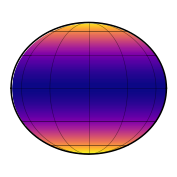

In [45]:
map33 = starry.Map(gdeg=4, oblate=True) #ydeg = 2*order_approx udeg=2
map33.omega=0.6
map33.beta=0.23
map33.wav=510
map33.tpole=8500
map33.f = f
map33.show()

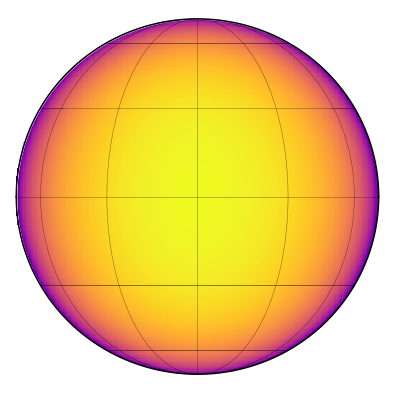

In [86]:
map33 = starry.Map(ydeg=2, udeg=2, oblate=True) #ydeg = 2*order_approx udeg=2

lat, lon, Y2P, P2Y, Dx, Dy = map33.get_pixel_transforms()
phi = np.radians(lat)
theta = np.radians(lon)
x = np.cos(phi) * np.cos(theta)
y = np.cos(phi) * np.sin(theta)
z = np.sin(phi)

flux_map = utils.flux_oblate(x, y, wav=5.1e-7, omega=omega_s, beta=0.23, tpole=8500)
y = P2Y.dot(flux_map)
map33[1:, :] = y[1:] / y[0]
map33.amp = y[0]
map33.f = f
map33[1] = 0.22
map33[2] = 0.28
fig = map33.show(figsize=(7,7),colorbar=False)

In [4]:
y = P2Y.dot(flux_map)
map33[1:, :] = y[1:] / y[0]
map33.amp = y[0]
map33.f = f
star = starry.Primary(map33, m=M_star, r=R_star,prot=100000)
star.map.inc=90-inc
#star.map[1] = 0#u1
#star.map[2] = 0#u2
theta = np.linspace(0, 360, 50)
fig = star.map.show(theta=theta, figsize=(7,7),colorbar=False)

In [87]:
xo = np.linspace(-1.2, 1.2, 500)
map33.obl = 0
map33.inc = 90

In [88]:
%%time
flux_obl = map33.flux(xo=xo, yo=0.3, ro=r_p)

CPU times: user 132 ms, sys: 4.61 ms, total: 136 ms
Wall time: 395 ms


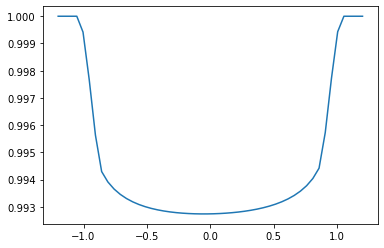

In [63]:
map33.obl = 20
map33.inc = 90
flux_obl = map33.flux(xo=xo, yo=0.3, ro=r_p)
plt.plot(xo, flux_obl / flux_obl[0])

In [8]:
len(y)

9

Now, let's create a planet (also modeled on WASP-33b)

In [9]:
planet = starry.kepler.Secondary(map=starry.Map(lmax=2),
    m=0,  # mass in solar masses
    r=r_p*star.r,#0.1087*star.r,  # radius in solar radii
    porb=1.2198681,  # orbital period in days
    inc=i_p,#88.01,
    Omega=long_p,#92,  # longitude of ascending node in degrees
    ecc=0.0,  # eccentricity
    w=0,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

system = starry.System(star, planet)

In [10]:
system.secondaries

(<starry.kepler.Secondary at 0x1a34c0f9e8>,)

### Creating lightcurves and comparing to real data!

In [11]:
system.flux(0.0); #hack to compile and create lightcurves faster

NotImplementedError: Oblate core not yet implemented.

In [ ]:
omega_s

In [ ]:
time = np.linspace(planet.porb-0.15, planet.porb+0.15, 500)
flux_star, flux_planet = system.flux(time, total=False)

In [ ]:
system.show(t=0, window_pad=4, figsize=(8, 8))

In [12]:
starry.config.lazy = False
import theano.tensor as tt
import theano.sparse as ts
import theano
x, y, z = system.position(time)

NameError: name 'time' is not defined

In [ ]:
_, xo = x
_, yo = y
_star, zo = z

In [ ]:
bo = np.sqrt(xo**2+yo**2)/star.r
theta = np.arctan2(xo, yo)
f_eff = (utils.f_eff(omega_s, inc))
A = np.array(star.map.ops.A.eval().todense())

In [ ]:
print(utils.f(omega_s))
print(utils.f_eff(omega_s, inc))
star.map.rotate(axis=[1,0,0],theta=inc)

In [ ]:
from tqdm.notebook import tqdm

tT = np.zeros(star.map.N)
for n in range(star.map.N):
    tT[n] = utils.tT_numerical(np.array([0,2*np.pi]), (1-0), theta[0], n)
tTA = np.dot(tT,A)
amp_star = np.dot(tTA, star.map.y)


terms = star.map.N
fluxes = np.zeros_like(time)


for i in tqdm(range(len(time))):
    sT = utils.analytic_sT(f_eff, theta[i], bo[i], planet.r/star.r, terms)
    where_are_NaNs = np.isnan(sT)
    sT[where_are_NaNs] = 0 #ask rodrigo why nans
    sTA = np.dot(sT,A)
    sTAR = star.map.ops.tensordotRz(sTA.reshape(1,-1), np.array([theta[i]]))
    fluxes[i] = np.dot(sTA, star.map.y)
    
flux_oblate_ydeg2 = ((amp_star-fluxes)*star.map.amp)

In [ ]:
star.map.rotate(axis=[1,0,0],theta=-inc)
star.map.inc=90-inc
star.map.show(colorbar=True)

In [ ]:
#plt.plot(time, (flux_oblate_sa/flux_oblate_sa[0]),'b.',label='semi analytic')
plt.plot(time, flux_star/flux_star[0],label='starry internal')
plt.plot(time, (flux_oblate_ydeg2/flux_oblate_ydeg2[0]),label='analytic ydeg=2')
#plt.plot(time, (flux_oblate/flux_oblate[0]),label='analytic ydeg=4')
#plt.plot(time, (flux_oblate_precise/flux_oblate_precise[0]),label='analytic ydeg=10')


plt.legend()
#plt.savefig('precision-test.png',dpi=300)

In [ ]:
#plt.plot(time, (flux_oblate/flux_oblate_precise),label='ydeg4/ydeg10')
plt.plot(time, (flux_oblate_ydeg2/flux_oblate_precise),label='ydeg2/ydeg10')
plt.legend()
plt.savefig('precision-test_ydeg2_div.png',dpi=300)

In [43]:
%load_ext autoreload
%autoreload 2
import pytransit
from pytransit import OblateStarModel, QuadraticModel
print(pytransit.__file__)
tmo = OblateStarModel(sres=100, pres=10, rstar = 1.561)
tmc = QuadraticModel(interpolate=False)

time = np.linspace(1.2198696-0.15, 1.2198696+0.15, 50000)
tmo.set_data(time)
tmc.set_data(time)
print(pytransit.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/shashank/anaconda3/lib/python3.7/site-packages/PyTransit-2.5.1-py3.7.egg/pytransit/__init__.py
2.5.1


In [82]:
omega_s = np.abs(0.2)#/(np.sin(np.radians(90-inc))))
print(omega_s)
k = np.array([r_p])
p_rot = (2*np.pi*(R_star*Rsun)**(3/2))/(omega_s*(G_mks*M_star*Msun)**(1/2)*(60*60*24))
#p_rot = 100.0
print(p_rot) #rotation period in days
#i = 88.01
#t0, p, a, i, az, e, w = 0.0, 1.2198681, 3.614, 90*(np.pi/180), 90*(np.pi/180.), 0.0, 0.0 #real t0 is 2458792.63403
t0, p, a, i, az, e, w = 0.0, 1.2198681, 3.614, i_p*(np.pi/180), long_p*(np.pi/180.), 0.0, 0.0 #real t0 is 2458792.63403
rho, rperiod, tpole, phi, beta = 0.778, p_rot,7600, (inc)*(np.pi/180.), 0.22
#rho, rperiod, tpole, phi, beta = 0.59, 100,7400, -50.0*(np.pi/180.), 0.22
ldc = np.array([0.22, 0.28]) # Quadtratic limb darkening coefficients

0.2
0.8959723742729887


In [83]:
%%time
flux_om = tmo.evaluate_ps(k, rho, rperiod, tpole, phi, beta, ldc, t0, p, a, i, az, e, w)

CPU times: user 10.9 ms, sys: 116 µs, total: 11 ms
Wall time: 11.4 ms


In [ ]:
len(flux_om)

In [ ]:
%matplotlib notebook
df = pd.read_csv("/Users/shashank/Documents/Python Files/wasp33TESS_clean.csv")
lc = lk.LightCurve(time=df.time,flux=df.flux)
wasp33_params = {'Epoch':2458792.63403-2457000, 'period':1.2198696,'tdur':0.1300}

fold = lc.fold(wasp33_params['period'],wasp33_params['Epoch'])
#plt.xlim(planet.porb-0.1,planet.porb+0.1)
plt.scatter(fold.phase*wasp33_params['period']+wasp33_params['period'],fold.flux,s=1)
plt.plot(time,flux_om, lw=2, c='k')

<IPython.core.display.Javascript object>


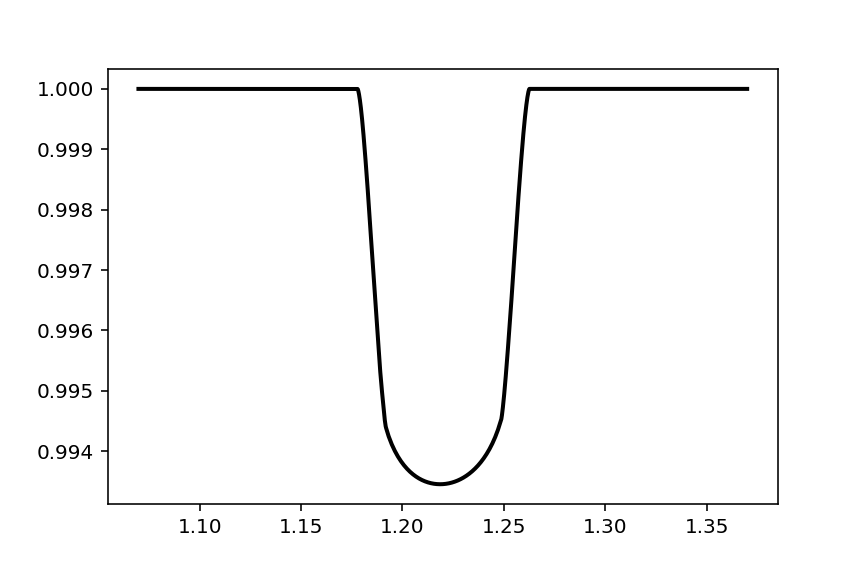

In [89]:
%matplotlib notebook
plt.plot(time,flux_om, lw=2, c='k') 
#plt.plot(time,flux_obl/flux_obl[0], lw=2, c='b')

In [ ]:
plt.imshow(star.map.render())

In [ ]:
b = 0.0
grids = tmo.visualize(1, b, long_p*(np.pi/180.), rho, rperiod, tpole, phi, beta, np.array([0,0]), ires=1000)

In [ ]:
flux_arr = []
im = grids.reshape(1000,1000)
for b_o in zip(bo):
    ranges = 1/0.91
    pts = np.linspace(-ranges, ranges, 1000)
    x, y = np.meshgrid(pts, pts)
    theta = np.radians(0)
    under_occultor = x ** 2 + (y - b_o) ** 2 <= (r_p)**2
    dA = (ranges*2)**2/ (x.shape[0] * x.shape[1])
    
    integral = (np.nanmean(im)*np.pi - np.nansum(im[under_occultor])*(dA))/(np.nanmean(im)*np.pi)
    flux_arr.append(integral)

In [ ]:
pts = np.linspace(-1/0.91, 1/0.91, 1000)
x, y = np.meshgrid(pts, pts)
theta = np.radians(0)
xr = (x * np.cos(theta) + y * np.sin(theta))
yr = (-x * np.sin(theta) + y * np.cos(theta))
under_occultor = x ** 2 + ((y - bo[250])) ** 2 <= r_p**2
in_star = (xr ** 2) + (yr ** 2)/(1-f_eff)**2 <= 1

In [ ]:
np.nanmean(im[under_occultor])

In [ ]:
plt.imshow(im, extent=[-ranges,ranges,-ranges,ranges])
plt.imshow(under_occultor,alpha=0.2, extent=[-ranges,ranges,-ranges,ranges])
plt.imshow(in_star,alpha=0.2, extent=[-ranges,ranges,-ranges,ranges])

In [ ]:
plt.plot(flux_arr/flux_arr[0],label='Brute force (mine)')
plt.plot(flux_star/flux_star[0],c='r', label='Starry internal')
plt.plot(flux_oblate/flux_oblate[0], label='Semi-analytic (mine)')
plt.plot(flux_om, label='pytransit internal')
plt.legend()

In [ ]:
plt.plot(flux_arr/flux_arr[0],label='Brute force (impact parameter matching starry)')
plt.plot(flux_star/flux_star[0],c='r', label='Starry internal')
plt.plot(flux_om, label='pytransit internal')
plt.legend()

In [ ]:
plt.plot(flux_arr/flux_arr[0],label='Brute force (impact parameter matching starry)')
plt.plot(flux_star/flux_star[0],c='r', label='Starry internal')
plt.plot(flux_om, label='pytransit internal')
plt.legend()

In [ ]:
plt.plot(fluxes*star.map.amp)

In [ ]:
import imp
imp.find_module('pytransit')

In [ ]:
print(utils.f(1.0))

In [42]:
pytransit.__version__

NameError: name 'pytransit' is not defined